# Lab 6 - Denoising

In this lab we will use denoising to clean up some noisy recordings. We will use the following sounds:

Speech in a room: [https://drive.google.com/uc?export=download&id=1g5nbBpNbCjqs8cSoW0Lb-owe15tswDwW ]

ATC: [https://drive.google.com/uc?export=download&id=1fh5iL5qRj3-PUP_sG5-QE5DofACY_Hr5 ]

Speech with wind: [https://drive.google.com/uc?export=download&id=1g7TIkLpnWDFNUQYgCqIUoSOkk5EIK16_ ]



## Part 1. Cleaning up the sounds

Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the recording so that you can learn a noise profile from there. Do the following:
Perform an STFT of the recordings

- Estimate the magnitude spectrum of the noise from the beginning of the recording
    - It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)

- Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT
    - Remember to clip any resulting negative values to zero
    - Try to find how much of the noise to subtract so that the output looks good

- Use the original signal’s phase to convert back to a time series.

Make a note of which examples sound the best and are easier to work with. Try to explain why.
At this point some of the outputs will exhibit “musical noise”. To minimize its effects apply a median filter on the denoised magnitude spectrogram to make it sound better (hint: ```scipy.signal.medfilt2```). How big should the median window be? Try different values and find which work best.


In [1]:
import numpy as np
import math
import IPython
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import scipy.signal as sgn

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    padZeroes = np.zeros(dft_size)
    pad = np.append(padZeroes, input_sound)
    pad = np.append(pad, padZeroes)
    tempMatrix = []
    for i in range(0, len(pad)-dft_size, hop_size):
        tempMatrix.append(pad[i:i+dft_size] * window)
    out = []
    for i in range(len(tempMatrix)):
        rfft = np.fft.rfft(tempMatrix[i], dft_size+zero_pad)
        out.append(np.reshape(rfft, (-1, 1)))     
    return np.hstack(out)

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    irfftSounds = []
    for segment in stft_output.T:
        irfftSounds.append(np.fft.irfft(segment, dft_size+zero_pad))
    irfftSounds = np.array(irfftSounds)
    input_sound = np.zeros(dft_size+hop_size*(len(irfftSounds)-1))
    for i in range(len(irfftSounds)):
        input_sound[i*hop_size:i*hop_size+dft_size] += (irfftSounds[i][:dft_size] * window)
    input_sound = input_sound[dft_size:]
    return input_sound

    
def plotSpectrogramIndex(file, STFTresult, rate, label=''):
    freq = np.linspace(0, rate/2, STFTresult.shape[0])
    absSTFT = np.absolute(STFTresult)
    plt.pcolormesh(np.arange(absSTFT.shape[1]),freq, np.log(absSTFT + np.e))
    plt.title(label)
    plt.xlabel('Time')
    plt.ylabel('Freq')
    plt.show()
    
def plotSpectrogramTime(file, STFTresult, rate, label=''):
    time = np.linspace(0, len(file)/rate, STFTresult.shape[1])
    freq = np.linspace(0, rate/2, STFTresult.shape[0])
    absSTFT = np.absolute(STFTresult)
    plt.pcolormesh(time, freq, np.log(absSTFT + np.e))
    plt.title(label)
    plt.xlabel('Time')
    plt.ylabel('Freq')
    plt.show()
    
# def plotFreq(originalSTFT, newSTFT, rate, label=''):
#     fig, (spect, freq) = pp.subplots(2)
#     fig.suptitle(label)
    
#     time = np.linspace(0, len(file)/rate, STFTresult.shape[1])
#     freq = np.linspace(0, rate/2, STFTresult.shape[0])
#     absSTFT = np.absolute(STFTresult)
#     spect.pcolormesh(time, freq, np.log(absSTFT + np.e))
#     plt.title(label)
#     plt.xlabel('Time')
#     plt.ylabel('Freq')
    
#     plt.plot(originalSTFT)
#     plt.title(label)
#     plt.show()

In [2]:
# YOUR CODE HERE
# find the average column of noise for the sound and subtract that from all the other columns, if it's negative make it zero
# you have to subtract that magnitude from the other magnitudes,(find out what the magnitudes should be)
# but you want the complex numbers to be preserved so you scale
def spectralSubtraction(stft, mean, alpha):
    spectFilter = np.zeros(np.shape(stft.T), dtype='complex')
    for i,freq in enumerate(stft.T):
        spectFilter[i] = (np.abs(freq) - alpha * np.abs(mean)).clip(min=0)*np.exp(1j * np.angle(freq))
    return spectFilter.T

def medianFilter(stft, spectFilter, kernel_size):
    medfilt = sgn.medfilt2d(np.abs(spectFilter), kernel_size)
    medianFilter = np.zeros(np.shape(stft), dtype='complex')
    for j in range(medfilt.shape[1]):
        medianFilter[:, j] = np.abs(medfilt[:, j]) * np.exp(1j * np.angle(stft[:, j]))
    return medianFilter

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

dft_size = 1024
hop_size = int(dft_size/4)
zero_pad = 0
alpha = 3
kernel_size = 1
window = np.hanning(dft_size)

## Room

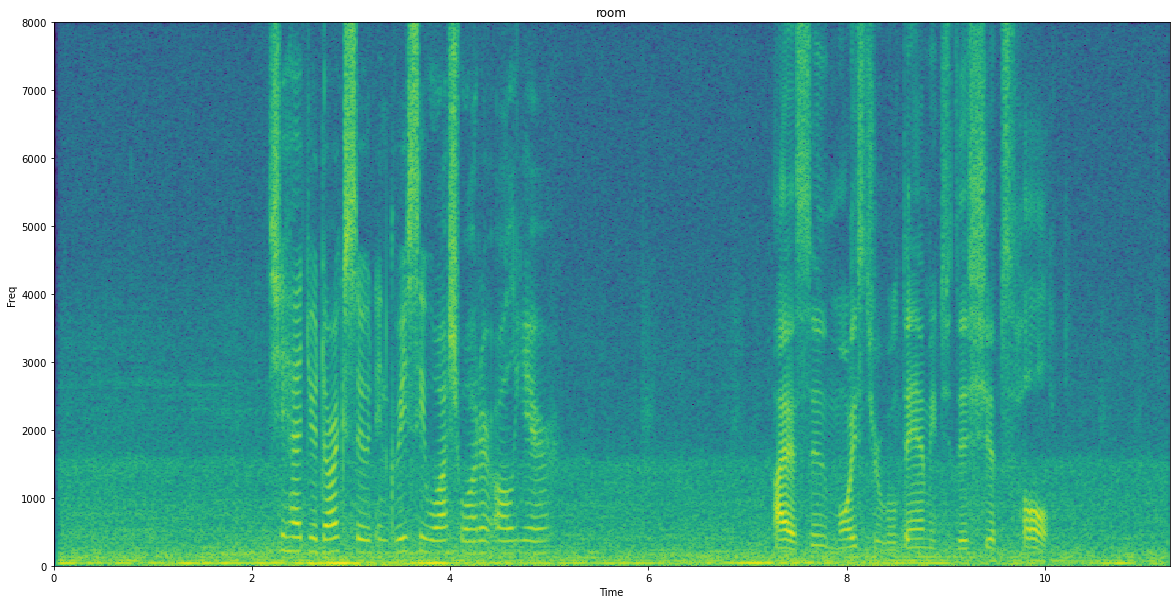

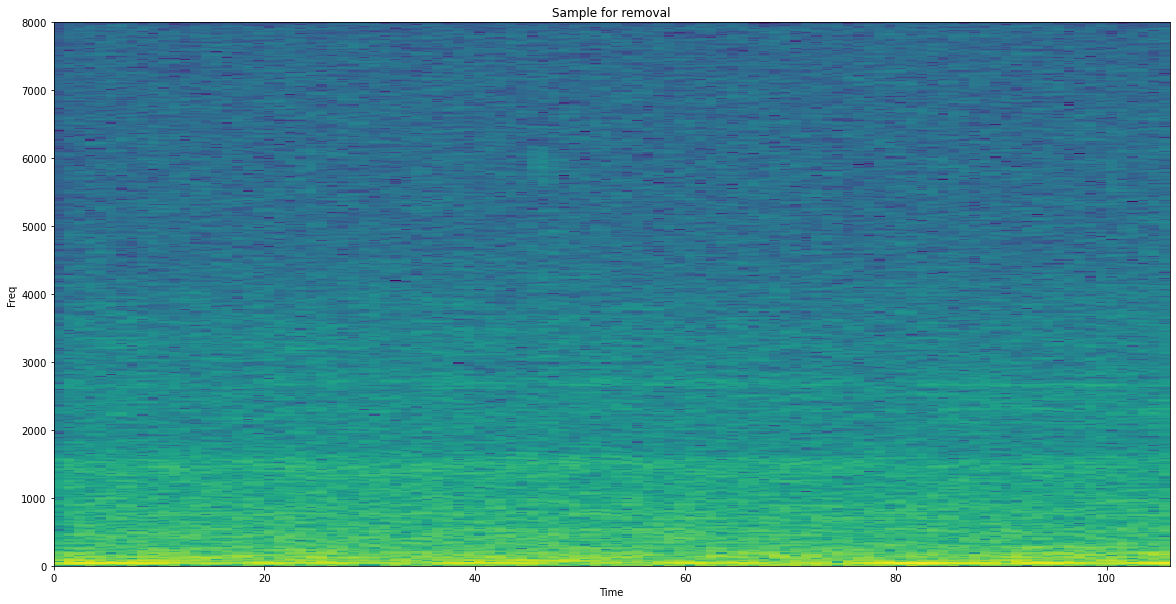

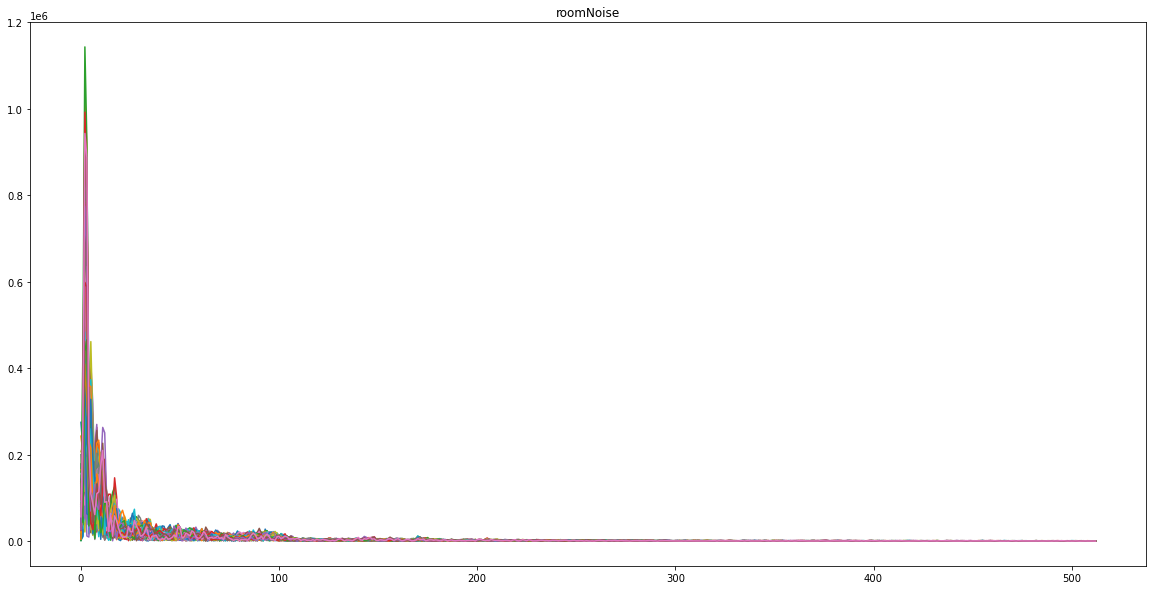

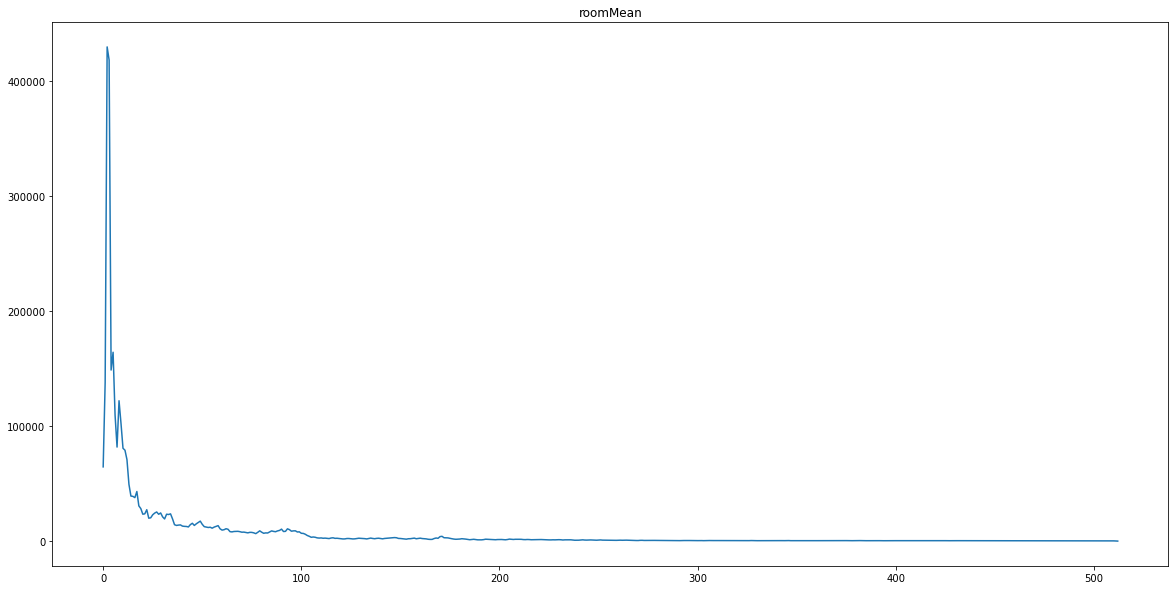

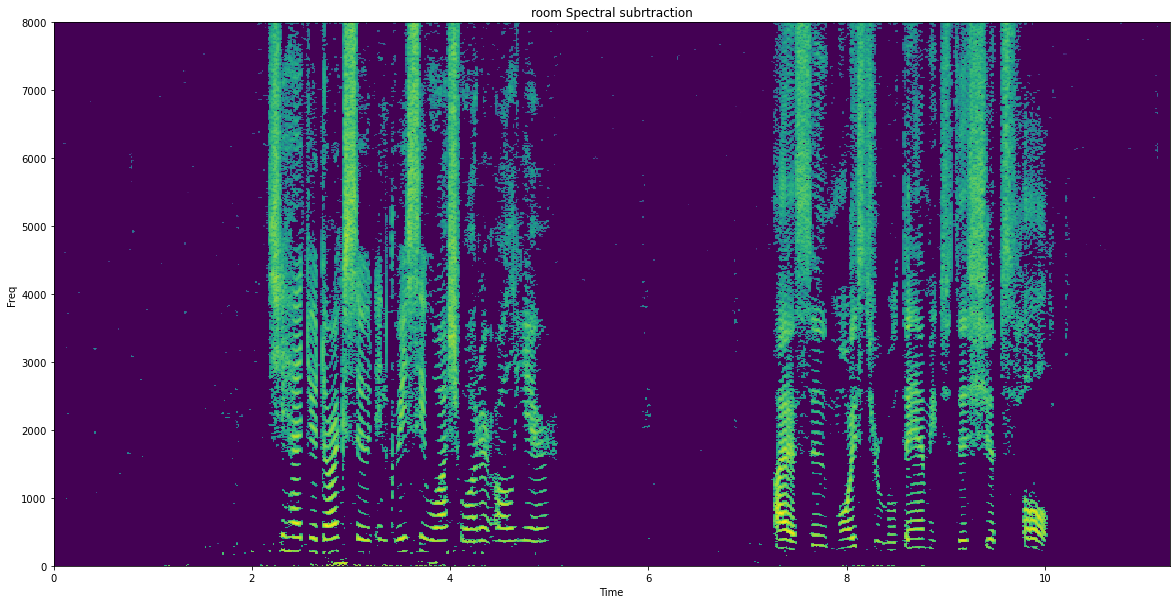

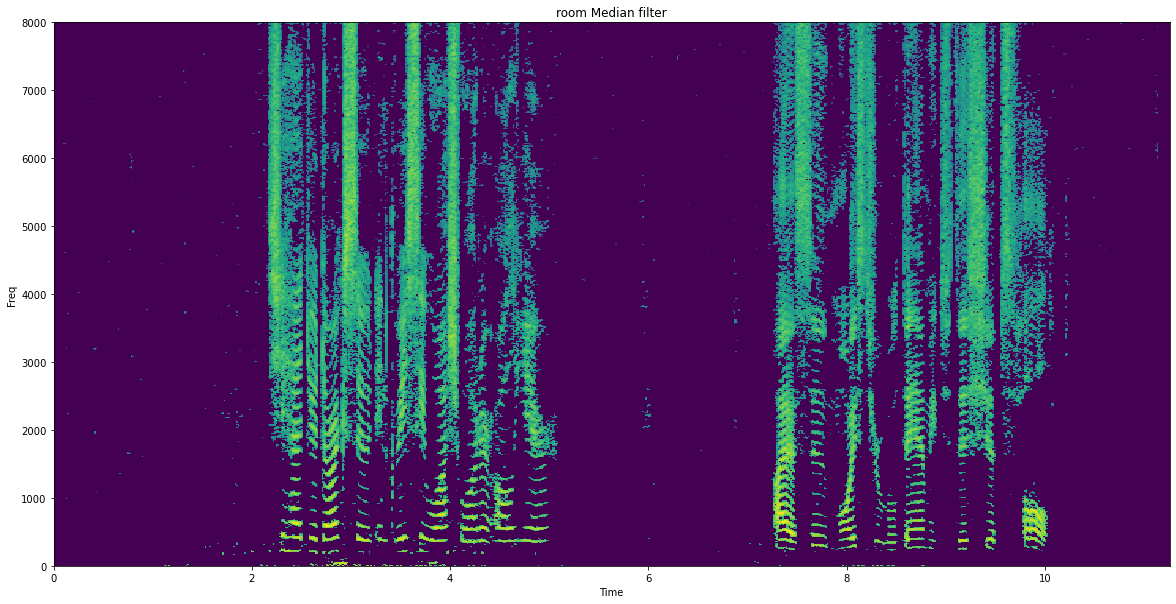

In [4]:
#Room
roomRate, room = wavfile.read('room-speech.wav')
roomSTFT = stft(room, dft_size, hop_size, 0, window)
plotSpectrogramTime(room, roomSTFT, roomRate, 'room')
sound(room, roomRate, 'room')


#Get Noise Sample
roomNoise = np.abs(roomSTFT[:, 3:110])
plotSpectrogramIndex(roomSTFT, roomNoise, roomRate,"Sample for removal")
plt.plot(roomNoise)
plt.title('roomNoise')
plt.show()

#Get mean
roomMean = np.mean(roomNoise, axis=1)
plt.plot(roomMean)
plt.title('roomMean')
plt.show()

#Spectral subtraction
roomSpect = spectralSubtraction(roomSTFT, roomMean, alpha)
roomSpectAudio = istft(roomSpect, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(room, roomSpect, roomRate, 'room Spectral subrtraction')
sound(roomSpectAudio, roomRate, 'roomSpectAudio')


#Median Filtering
roomMedian = medianFilter(roomSTFT, roomSpect, kernel_size)
roomMedianAudio = istft(roomMedian, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(room, roomMedian, roomRate, 'room Median filter')
sound(roomMedianAudio, roomRate, 'roomMedianAudio')

In [5]:
# plt.plot(roomSTFT)
# plt.title('room')
# plt.show()

# plt.plot(roomSTFT[:, 3:110])
# plt.title('roomNoise')
# plt.show()

# plt.plot(roomSpect)
# plt.title('roomSpect')
# plt.show()

# plt.plot(roomMedian)
# plt.title('roomMedian')
# plt.show()

## AirComm

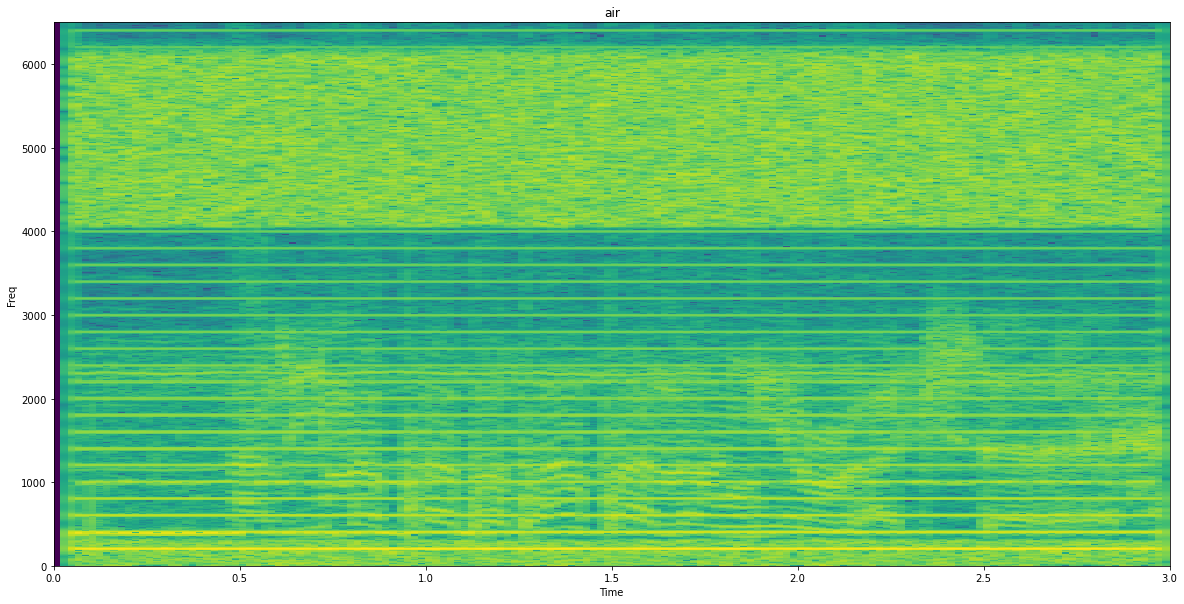

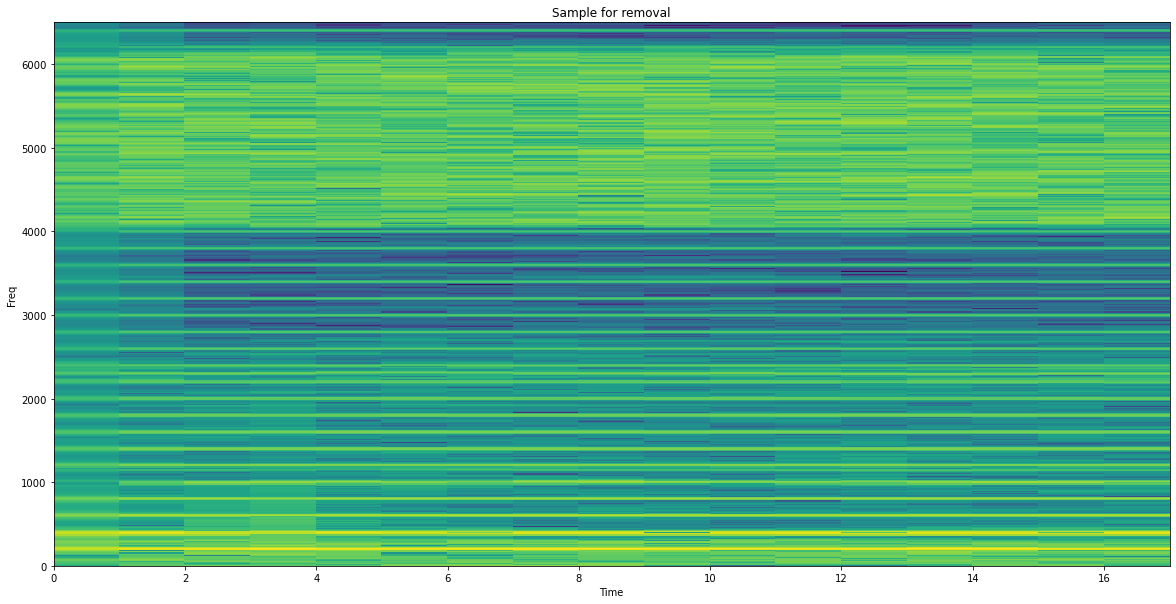

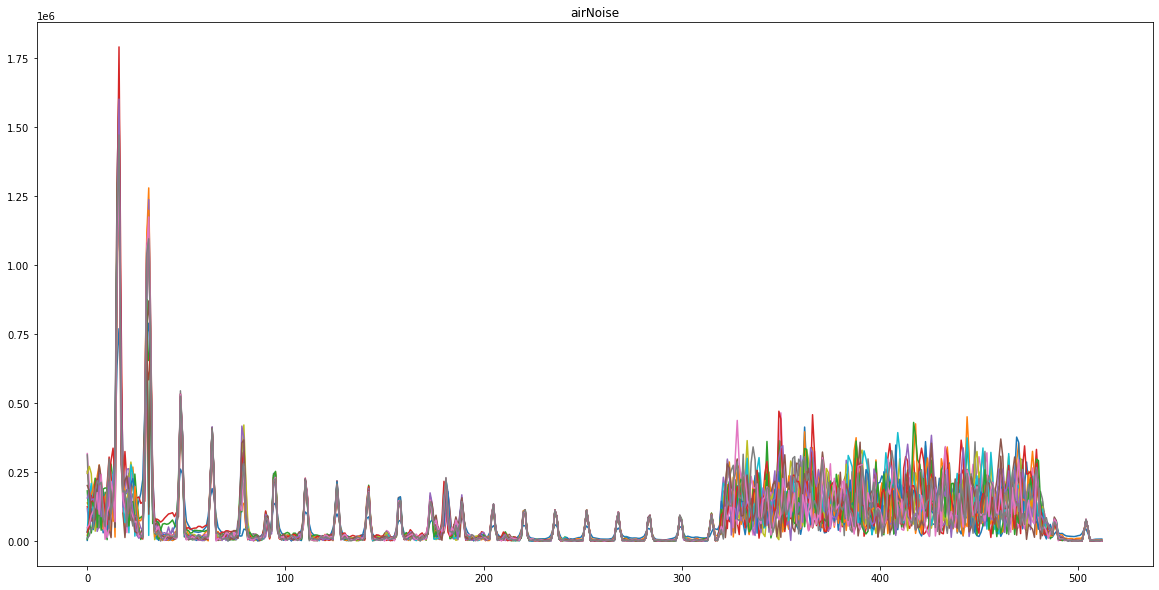

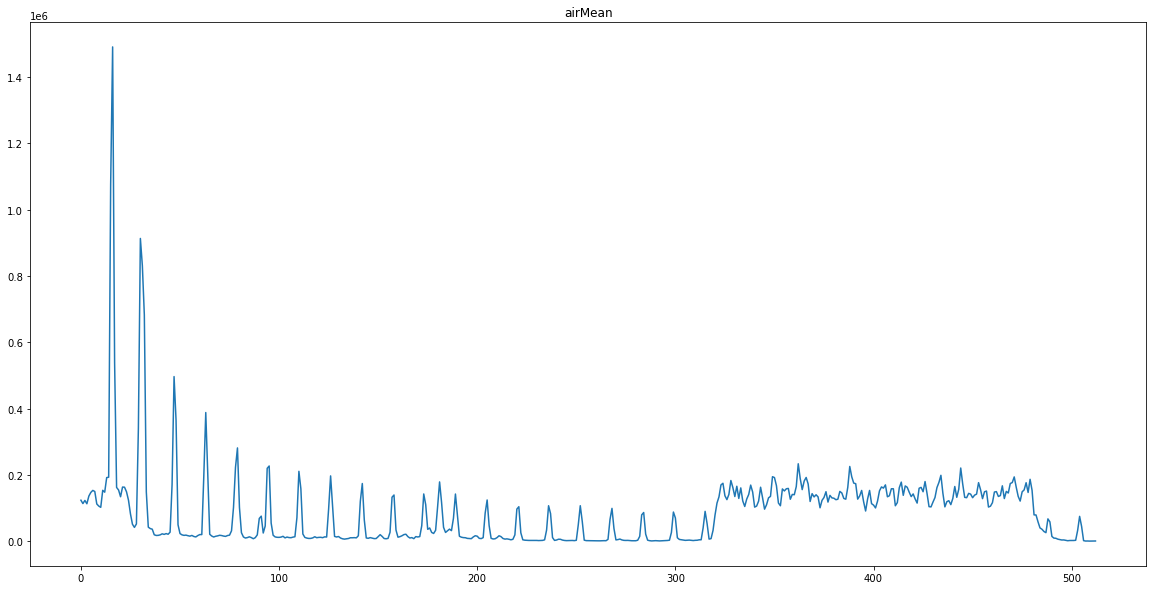

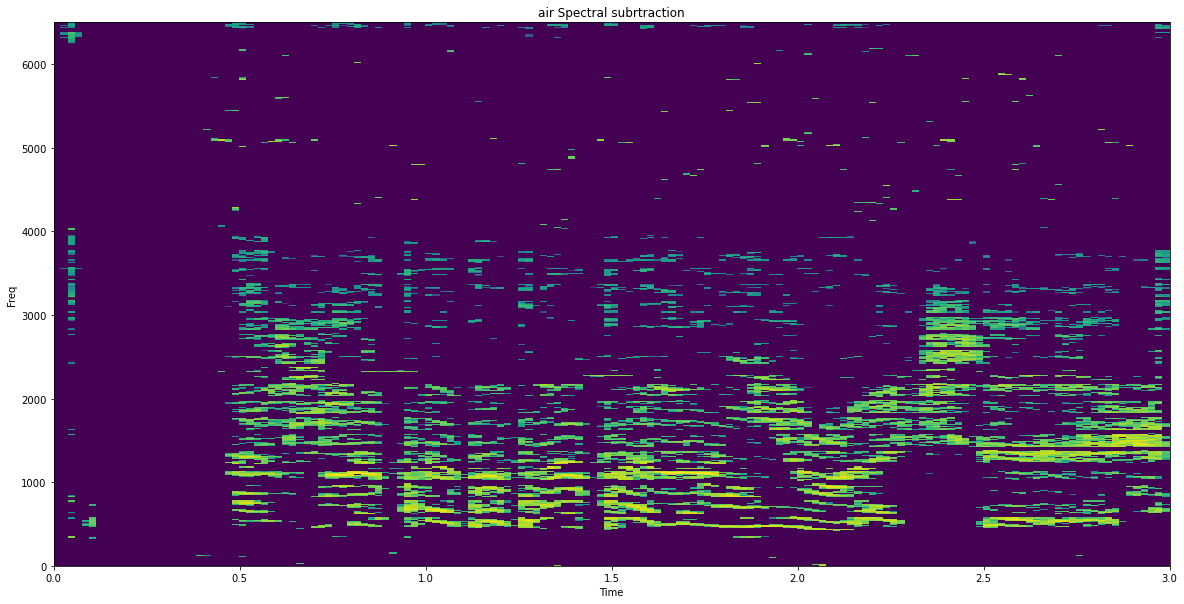

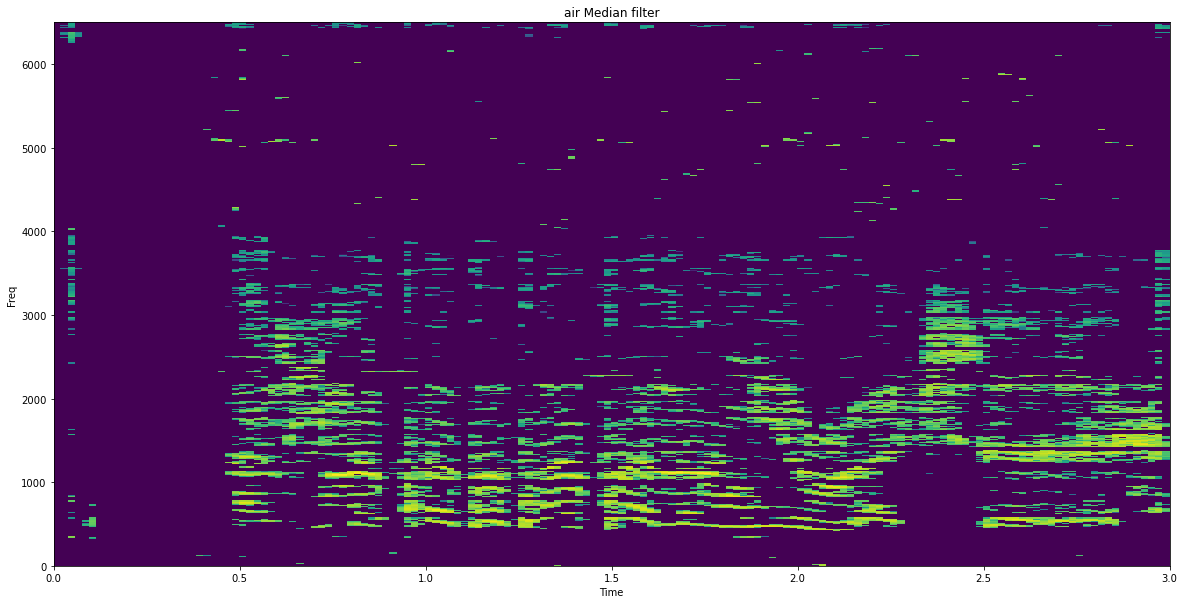

In [6]:
#aircomm
airRate, air = wavfile.read('aircomm.wav')
airSTFT = stft(air, dft_size, hop_size, 0, window)
plotSpectrogramTime(air, airSTFT, airRate, 'air')
sound(air, airRate, 'air')

#Get Noise Sample
airNoise = np.abs(airSTFT[:, 2:20])
plotSpectrogramIndex(airSTFT, airNoise, airRate,"Sample for removal")
plt.plot(airNoise)
plt.title('airNoise')
plt.show()

#Get mean
airMean = np.mean(airNoise, axis=1)
plt.plot(airMean)
plt.title('airMean')
plt.show()

#Spectral subtraction
airSpect = spectralSubtraction(airSTFT, airMean, alpha)
airSpectAudio = istft(airSpect, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(air, airSpect, airRate, 'air Spectral subrtraction')
sound(airSpectAudio, airRate, 'airSpectAudio')


#Median Filtering
airMedian = medianFilter(airSTFT, airSpect, kernel_size)
airMedianAudio = istft(airMedian, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(air, airMedian, airRate, 'air Median filter')
sound(airMedianAudio, airRate, 'airMedianAudio')

## Wind

<ipython-input-7-98b31c6692d7>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  windRate, wind = wavfile.read('wind-speech.wav')


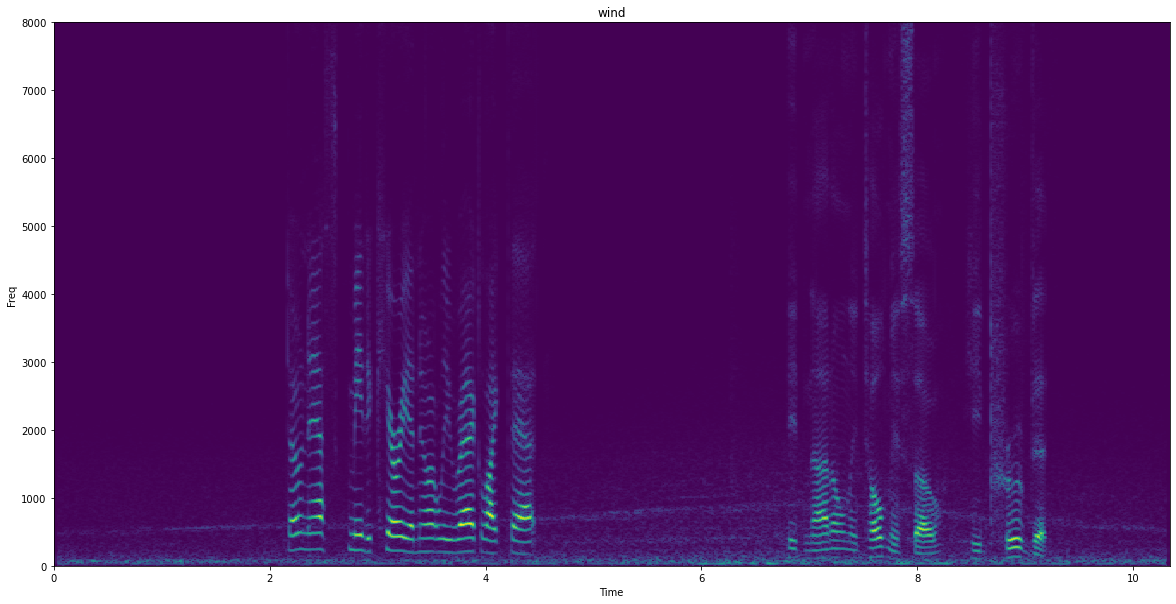

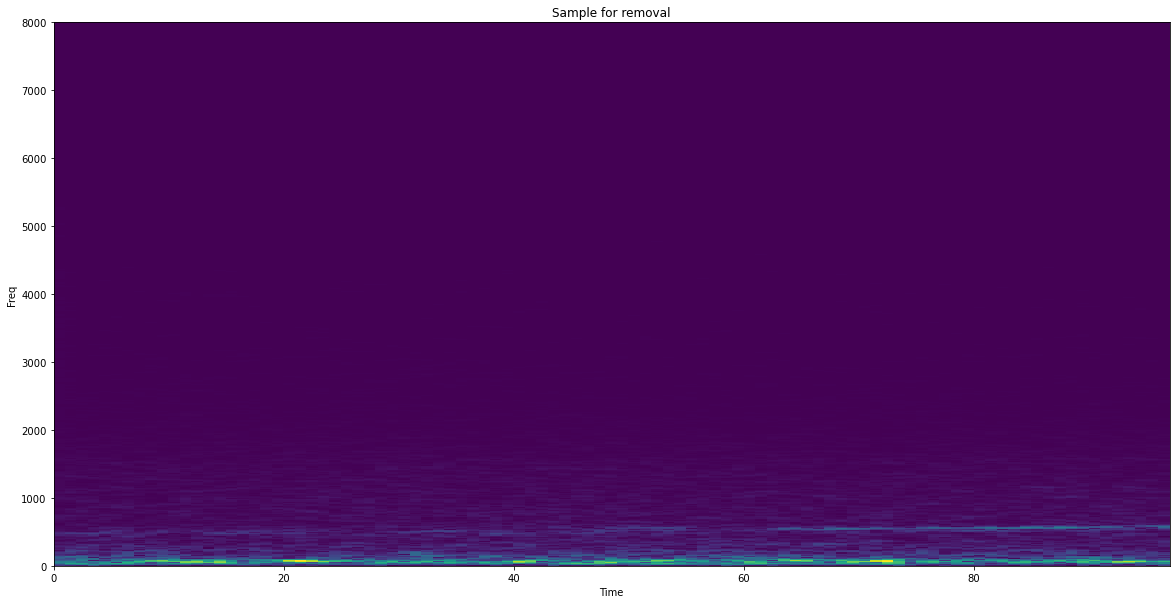

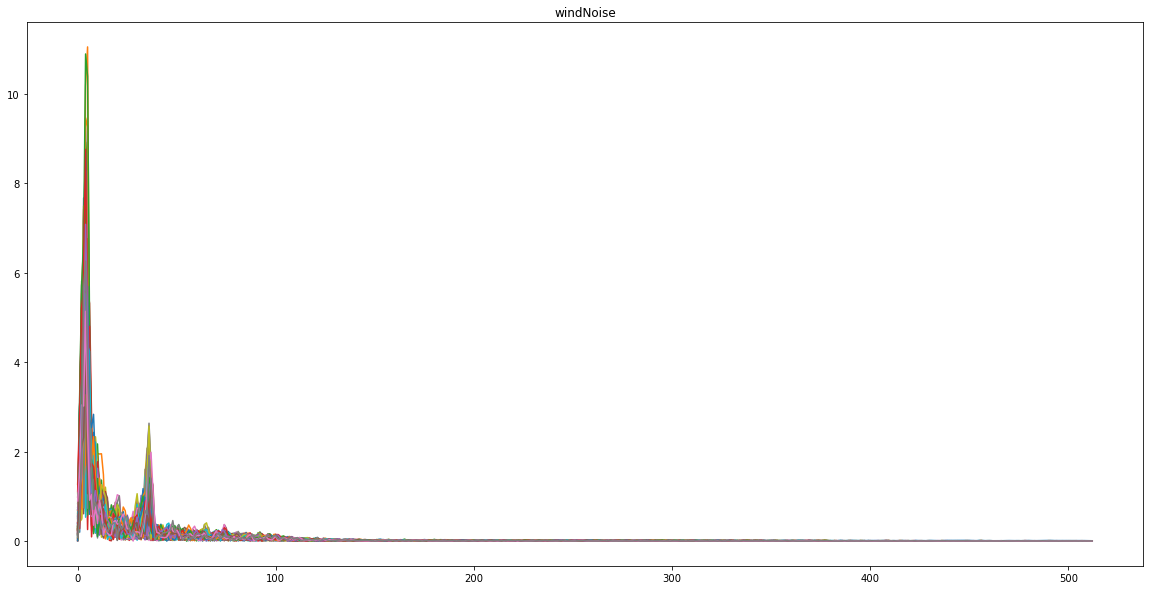

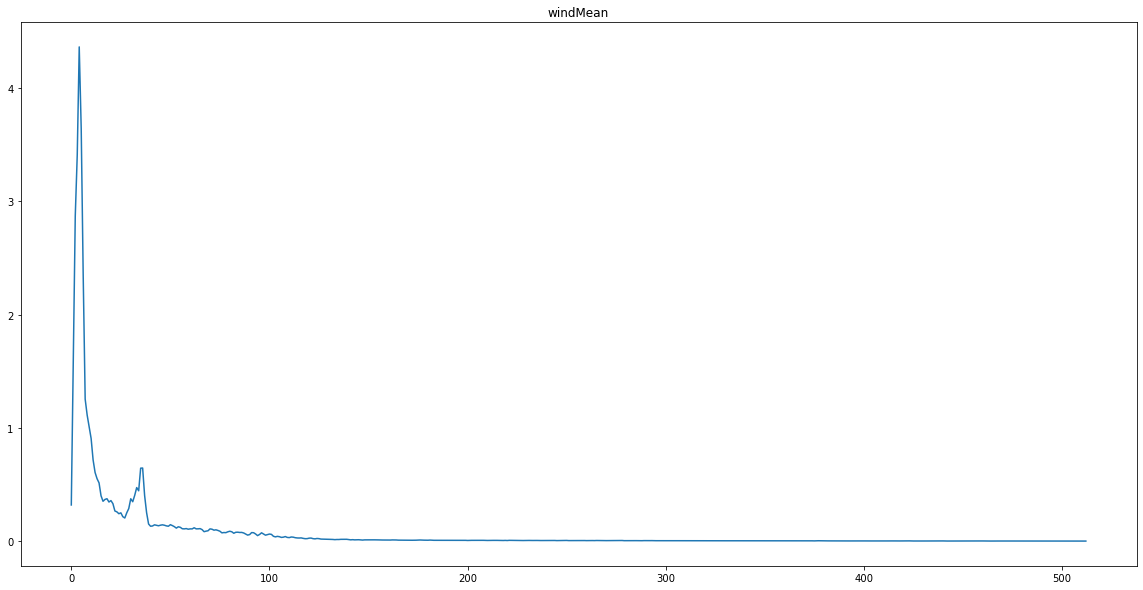

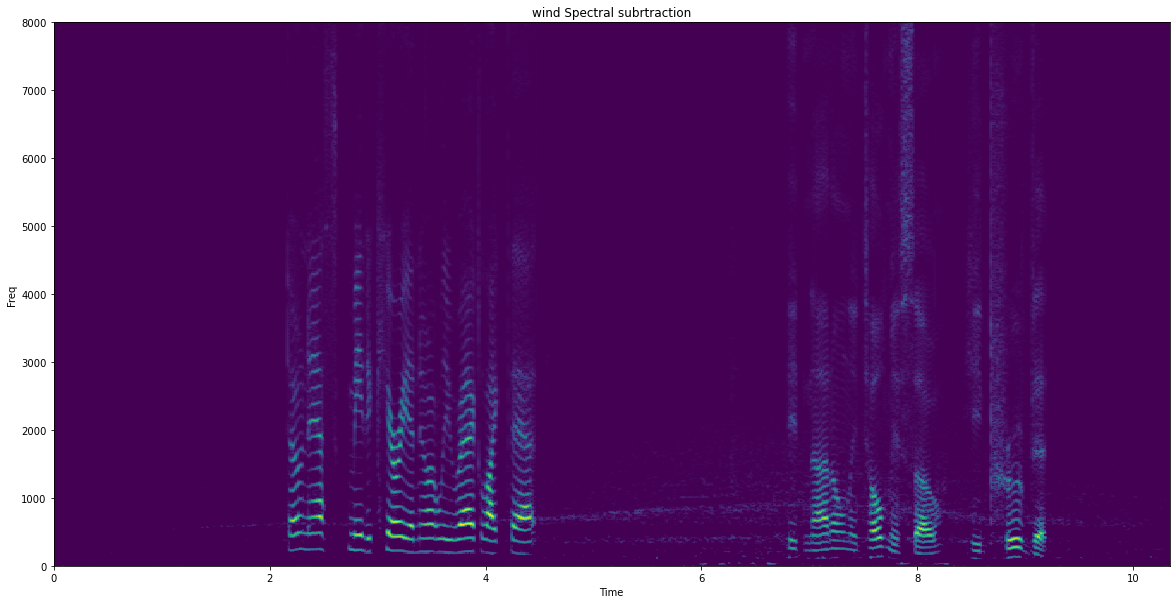

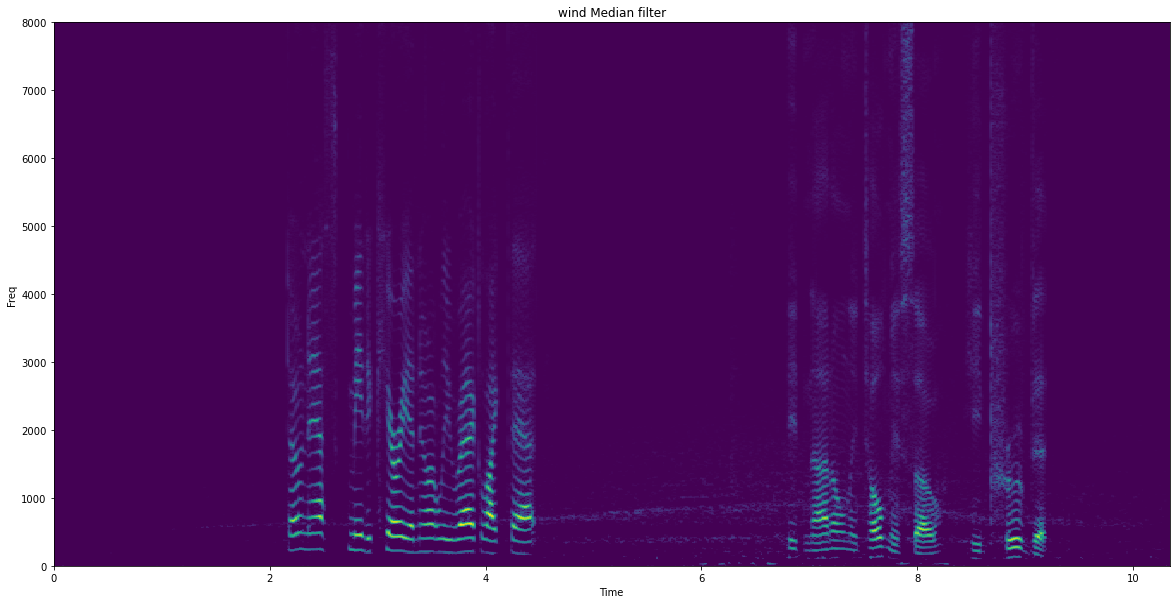

In [7]:
#wind
windRate, wind = wavfile.read('wind-speech.wav')
windSTFT = stft(wind, dft_size, hop_size, 0, window)
plotSpectrogramTime(wind, windSTFT, windRate, 'wind')
sound(wind, windRate, 'wind')

#Get Noise Sample
windNoise = np.abs(windSTFT[:, 2:100])
plotSpectrogramIndex(windSTFT, windNoise, windRate,"Sample for removal")
plt.plot(windNoise)
plt.title('windNoise')
plt.show()

#Get mean
windMean = np.mean(windNoise, axis=1)
plt.plot(windMean)
plt.title('windMean')
plt.show()

#Spectral subtraction
windSpect = spectralSubtraction(windSTFT, windMean, alpha)
windSpectAudio = istft(windSpect, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(wind, windSpect, windRate, 'wind Spectral subrtraction')
sound(windSpectAudio, windRate, 'windSpectAudio')


#Median Filtering
windMedian = medianFilter(windSTFT, windSpect, kernel_size)
windMedianAudio = istft(windMedian, dft_size, hop_size, zero_pad, window)
plotSpectrogramTime(wind, windMedian, windRate, 'wind Median filter')
sound(windMedianAudio, windRate, 'windMedianAudio')

## Notes:
#### I found that the room sound was the easiest to work with and sounds the best because the noise was quiet, consistent, and it was more of a 'background' sound.  Removing it through filtering was simple because it was as if you were just trying to make the spectrogram less blurry.

#### The AirComm sound was difficult to make comprehendable through filtering because the sound to remove was very loud and overpowered the speech audio. As seen in my frequency graph, the Aircomm noise also had 'bands' of frequencies spread throughout the entire file. While I was able to remove the noise, in order to remove these sounds, I had to effectively remove these frequencies entirely, meaning they were removed from the speech audio as well.

#### The wind audio file was already comprehendable from the original, but there was a problematic sound of musical noise from the wind.  As discussed in lecture, this noise is an example of a nonstationary noise, which makes it particularly difficult to remove.  Spectral subtraction is only designed for stationary noise, and so it fails to completely remove the wind

## Part 2. Implement a Voice Activity Detector (VAD)


For the last sound we have an evolving noise profile, which causes problems since our noise description from the first two seconds isn’t accurate throughout. Because we’re lazy we want to automatically update the noise model and not to select it manually. To do so we need a VAD that lets us know when to gather noise statistics and when to denoise. Do the following:

- Take the square of the input waveform and lowpass filter it (a lot) to get an energy level over time
    - Experiment with the cutoff frequency so that you get a smooth energy-looking function
- Set a threshold over which we seem to have speech in the input
- Implement a real-time spectral subtraction denoiser
    - If an input frame is under threshold, it is noise
    - Keep track of the last few noise frames and their average amplitude will be your noise spectrum
    - If an input is over the threshold it is speech
    - Once you encounter speech perform spectral subtraction with the current noise estimate

513


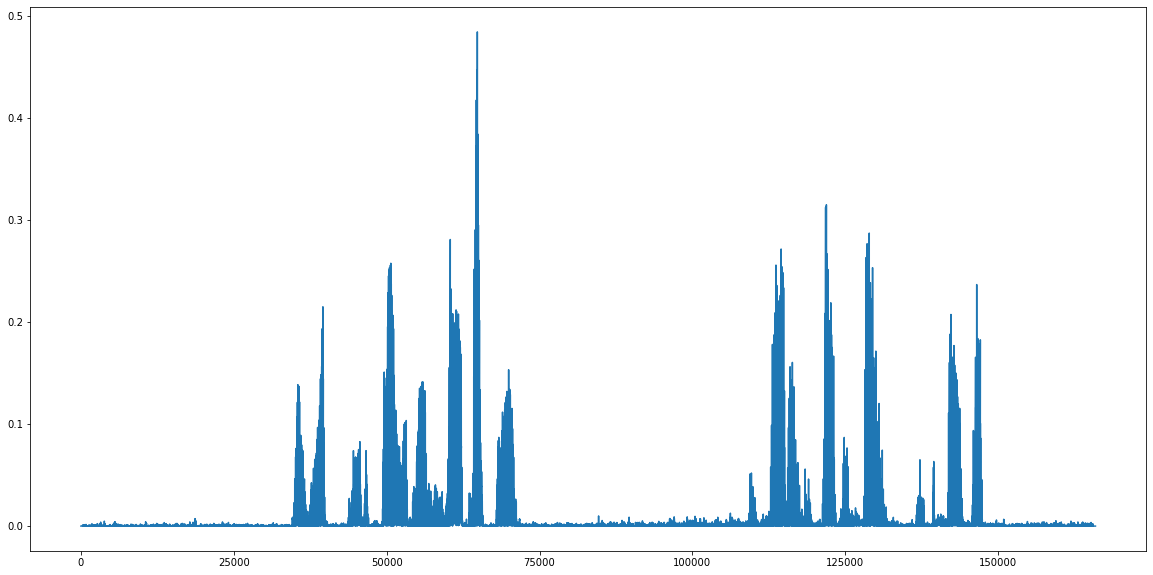

In [16]:
# YOUR CODE HERE
#create Energy
threshold = 0.002
windSq = np.square(wind)
lowpass_filt = sgn.firwin(numtaps=len(windSTFT), 
                                   cutoff=1000, pass_zero='lowpass', fs=windRate)
energy = np.abs(sgn.convolve(windSq, lowpass_filt))
energy = energy.clip(min=0)
plt.plot(energy)
# raise NotImplementedError()

In [17]:
def stftActiveFrames(input_sound, dft_size, hop_size, zero_pad, window, energy,threshold):
    padZeroes = np.zeros(dft_size)
    pad = np.append(padZeroes, input_sound)
    pad = np.append(pad, padZeroes)
    
    active = (energy > threshold)
    active.astype(np.int)
    active = np.append(padZeroes, active)
    active = np.append(active, padZeroes)
    
    tempMatrix = []
    activeFrames = []
    for i in range(0, len(pad)-dft_size, hop_size):
        tempMatrix.append(pad[i:i+dft_size] * window)
        if (np.any(active[i:i+dft_size])):
            activeFrames.append(True)
        else:
            activeFrames.append(False)
            
    out = []
    for i in range(len(tempMatrix)):
        rfft = np.fft.rfft(tempMatrix[i], dft_size+zero_pad)
        out.append(np.reshape(rfft, (-1, 1)))
    return np.hstack(out), activeFrames

In [18]:
windSTFT, windActive = stftActiveFrames(wind, dft_size, hop_size, zero_pad, window,energy,threshold)

In [31]:
def VAD(sound, stft, energy, num, activeFrames, alpha, threshold):
    noise_frame_counter = 0
    VADfilter = []
    temp = np.zeros((num, stft.shape[0]), dtype="complex")
    for i in range(stft.shape[1]):
        if activeFrames[i]:
            mean = np.mean(np.abs(temp), axis=0) 
            VADfilter.append((np.abs(stft[:, i]) - alpha * mean).clip(min=0) * np.exp(1j * np.angle(stft[:, i])))
        else:
            temp[noise_frame_counter] = stft[:, i]
            VADfilter.append(np.zeros(stft[:, i].shape[0]))
            noise_frame_counter = (noise_frame_counter + 1) % num
    return np.array(VADfilter).T

In [32]:
VADfilter = VAD(wind, windSTFT, energy, 10, windActive, 3, 0.002)
VADfilterAudio = istft(VADfilter, dft_size, hop_size, zero_pad, window)

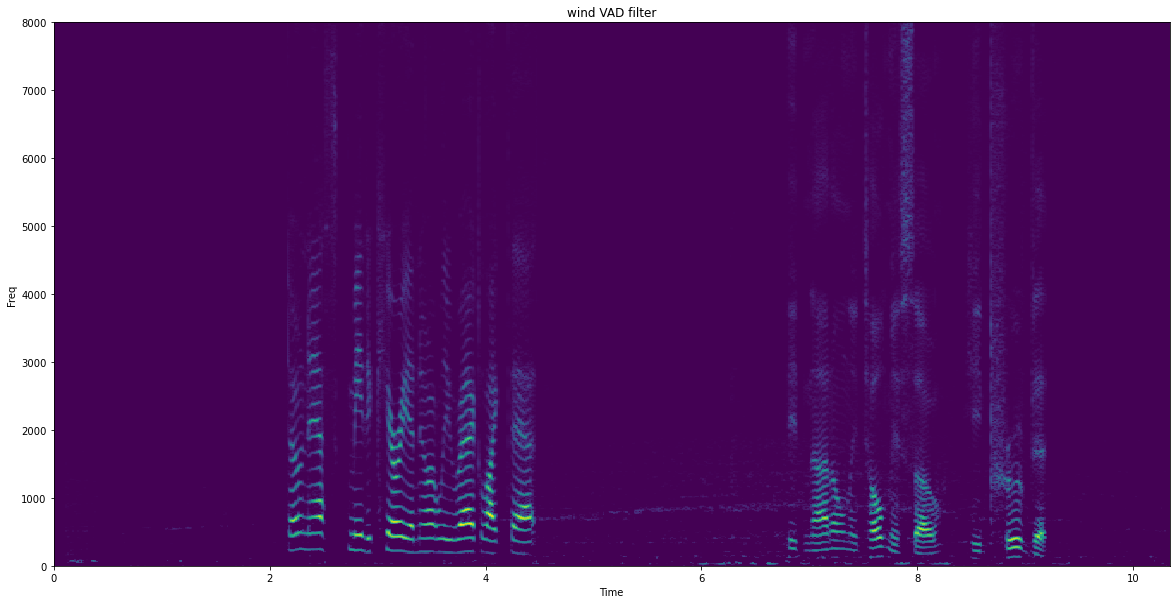

In [33]:
plotSpectrogramTime(wind, VADfilter, windRate, 'wind VAD filter')
sound(VADfilterAudio, windRate, 'VADfilterAudio')